# Codebase 2: Data Exploration

The target and feature data sets will be examined seperately before looking if any simple patterns are evident when grouping them together. Fully respecting the sancrosanct nature of the holdout set, only the data of the training set (1997 to 2014) will be considered. 

The first step is to load the required data in convenient format:

## (1) Drawdown Data

Let's start by exploring the structured target data of the maximum annual drawdown in the year following the filing of company annual reports.

In [15]:
import pandas as pd

#specify inputs
input_master = 'hold_out_2015_TfidfVectorizer_unigram.pickle'
x_drop_columns = ['ticker_', 'max_dd_1yr',
       'max_dd_2yr', 'custom_sector']

#load data
dict_master = pd.read_pickle(input_master)
#select training data df
df = dict_master['min_df_15']['df_train_master']
#drawdown df
df_dd = dict_master['min_df_15']['df_train_master'][['Filed_Date', 
                                        'ticker_', 'sector_','sic_sector', 
                                            'max_dd_1yr', 'year_dd_flag', 
                                                     'cum_year_dd_flag']]
#td-idf word vector df
df_wv = df.drop(x_drop_columns, axis=1)

#memory management
del dict_master, df


__(i) The first question we will investigate is the how positive events (max drawdowns >= 80%) look over time noting that we might expect the number of events to increase over periods of US economic stress.__

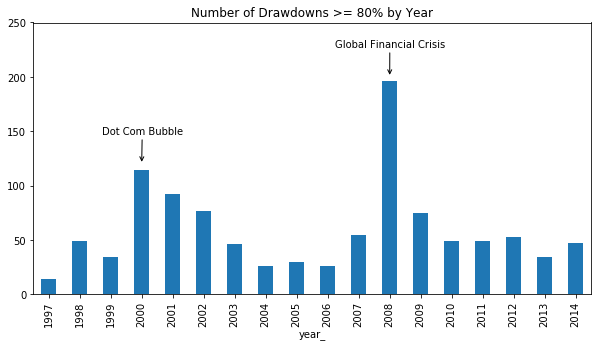

In [16]:
%matplotlib inline  

#Define pos events and wrap in df
mask_pos_events = df_dd['max_dd_1yr'] <= -0.8
pos_events = (mask_pos_events*1).values
df_events_ts = pd.DataFrame(pos_events, columns=['pos_event'])
#format and count by year groupby
df_events_ts['year_'] = (df_dd['Filed_Date'].dt.year).values
df_num_events = df_events_ts.groupby('year_').sum()[1:]

#Plot bar chart with annotations
_ = df_num_events.plot(kind='bar', title='Number of Drawdowns >= 80% by Year',
                      figsize=(10,5), ylim=(0,250), legend=False)

_.annotate('Dot Com Bubble',
            xy=(3, 120), xycoords='data',
            xytext=(-40, 30), textcoords='offset points',
            arrowprops=dict(arrowstyle="->"));
_.annotate('Global Financial Crisis',
            xy=(11, 200), xycoords='data',
            xytext=(-55, 30), textcoords='offset points',
            arrowprops=dict(arrowstyle="->"));


__Not surprisingly we see spikes over 2000/2001 and 2008/2009 which correspond to the US recessions over this time period.__ Namely the dot com bubble / Sep 11 attacks of 2000/2001 and the global fiinancial crisis of 2008/2009. This could be taken a  step further with an investigation of the correllation between the rate of change of these numbers and US GDP. Without presenting full results here, we note that there is evidence of a negative correlation with an expected lag (market leads GDP) between these variables. This is however relatively weak (45% over 1998-2014) outside of the extremes. 

__(iii) We might also suspect that certain sectors would be more vulnerable to the business cycle, or overvaluation, and exhibit higher rates of positive events. We will look at two measures for this: % of all positive events allocated to sector and the % of positive events for each sector.__

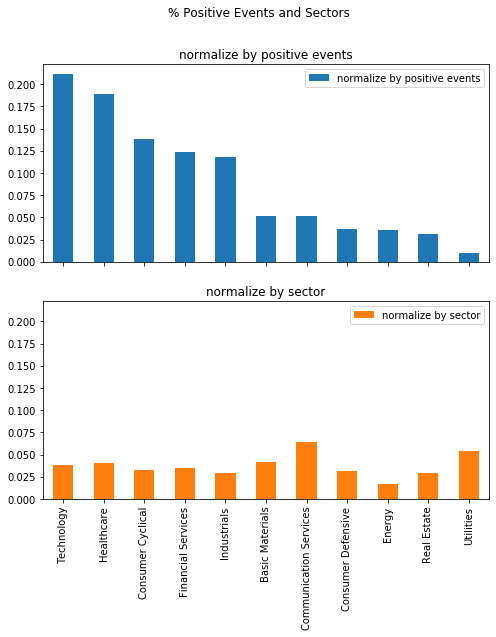

In [17]:
#ratio of positive events allocated to each sector
df_sector_pos = df_dd['sector_'][mask_pos_events]
df_sec_pos_num = df_sector_pos.value_counts(normalize=True)
df_sec_pos_num.name = 'normalize by positive events'

#ratio of positive events for each sectors
df_sector = pd.DataFrame(df_dd['sector_'])
df_sector['pos_events'] = pos_events
df_sec_num = df_sector.groupby('sector_').count()
df_sec_num_pos = df_sector.groupby('sector_').sum()
df_sec_ratio = df_sec_num_pos / df_sec_num
df_sec_ratio.columns = ['normalize by sector']
#move to single df
df_both = pd.concat([df_sec_pos_num, df_sec_ratio], axis=1)
#plot bar charts
_ = df_both.plot(kind='bar', title='% Positive Events and Sectors',
                subplots=True, sharey=True, figsize=(8,8))


__Certain sectors have a reputation for higher risk but the above graph reveals some surprising insights based on the classification taken from Sharadar. If we naively just look at what percentage of positive events can be allocated to each sector (blue) then we see that the top 5 sectors account for 78% of positive events with Technology and Healthcare accounting for 40%. However, this fails to account for bias and, in particular, how many companies (or annual reports) there are in the entire dataset. The orange bars do so by looking at the percentage of statements in each sector that have a positive event. An entirely different picture emerges in this case with communication services and utilities leading the pack. Utilities, which are normally low leverage with stable cash flow, is a curious one that would be worth further investigation on a per company basis. We also note (again) that the analysis only includes the training set and excludes the oil price collapse of 2015 likely flattering energy's performance in the above graphs.__

It should also be noted that Sharadar's sectoral classification is very braod and other classifications might be more interesting. For example, where each company operates in the industry supply chain could be more enlightening (manufacturing, distribution etc.). This is the purpose of including the sic_sector and custom_sector (concatenation of sector and sicsector) columns in the full analysis which could be pursued with more time or specific focus

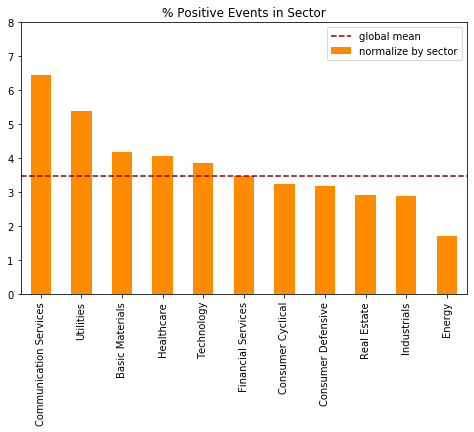

In [64]:
df_both = df_both.sort_values(by='normalize by sector')

_ = (df_both['normalize by sector'].sort_values(ascending=False)*100).plot(kind='bar', title='% Positive Events in Sector',
                figsize=(8,5), color='darkorange', ylim=(0.0,8))
ave = 3.48

_ = plt.axhline(ave, c='darkred',ls='--', label='global mean');
plt.legend();

In [71]:
ordered_sec = reversed(df_both.index.tolist())
print(ordered_sec)

__(iv) It would not be unreasonable for sector vulnerabilities to evolve overtime. For example, high rates of positive events for technology in the dotcom bubble (late 90s / early 00s) or the financial sector over the GFC might be expected.__

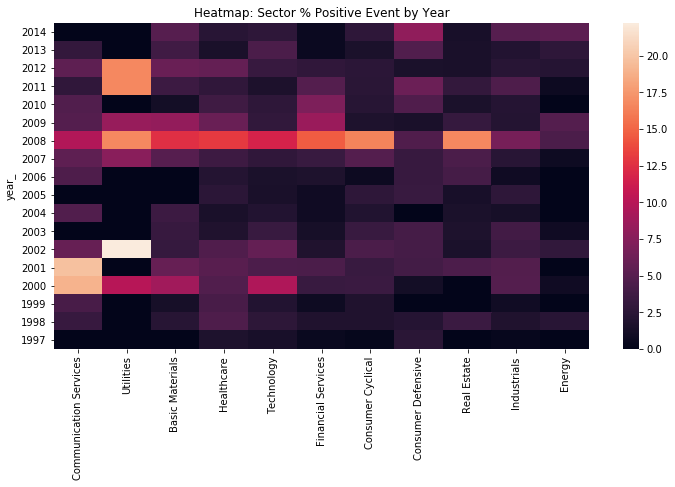

In [72]:
import matplotlib.pyplot as plt
import seaborn as sns

sector = 'sector_'

#select columns of interest and set date to year
df_sec_year = df_dd[['Filed_Date',sector,'year_dd_flag']]
df_sec_year.loc[:,'year_'] = (df_dd['Filed_Date'].dt.year).values
df_sec_year = df_sec_year.drop('Filed_Date', axis=1)
#Groupby year, sector and find % sector positive event
df_s_y_count = df_sec_year.groupby(['year_',sector]).count() 
df_s_y_sum = df_sec_year.groupby(['year_',sector]).sum() 
df_sec_year = 100*df_s_y_sum / df_s_y_count
#reshape and clean column names
df_sec_year = df_sec_year.unstack(level=1).sort_index(ascending=False).iloc[:-1,:]
cols = [tuples[1] for tuples in df_sec_year.columns]
df_sec_year.columns = cols

df_sec_year = df_sec_year[ordered_sec]



#plot heatmap
plt.figure(figsize=(12,6))
plt.title('Heatmap: Sector % Positive Event by Year')
_ = sns.heatmap(df_sec_year)

__The first observation is that the GFC in 2008 did not spare anyone with most sectors showing significant rates of threshhold drawdown. Within that we do notice that financial services was far hareder hit in 2008 than in any other year and that technology and communication services (likely to include early tech companies) were also hard hit in 2000. Again we note that utiities stands out in being hit hard over both recessions and again in 2011 and 2012.__ The analsysis only goes till 2014 and we might expect the energy industry to take a hard hit after this given the oil price collapse in late 2015. This will be a good test for the model.    

## (2) TF-IDF Matrix of Annual Reports

__(i) It will be interesting to see what words appear most frequently across the corpus:__

In [5]:
#drop description fields to obtain pure tdidf matrix
df_tdidf = df_wv.drop(['Filed_Date', 'sector_','sic_sector', 
                        'year_dd_flag', 'cum_year_dd_flag'], 
                                                        axis=1)

In [ ]:
#calculate mean tdidf score of each
#word across corpus (long run time)
s_wv_mean = df_tdidf.mean(axis=0)

In [ ]:
#top 25 words
print('Top 25 Corpus words by mean tdidf score')
print('')
print(s_wv_mean.sort_values(ascending=False)[:25])

__Despite the inverse document frquency weighting, there is a clear bias to technical terms of the heavily weighted sectors such as healthcare, energy, real estate and financial services.__ Somewhat dissapointingly, the numbers (and "rsquo")  all relate to unicode numbers from the html and xbrl tagging that preprocessing failed to remove. One solution would be to remove numeric characters but the decision was made to keep numbers as these could contain important information such as accounting, regulatory or legal classifications. The prepocessing failure is likely to be an equal afflcition across the corpus and should not result in bias to the model. However, this will need to be verified in the model results.   

__(ii) We might also expect document similarities to naturally cluster across sectors.__ 
Given the large size of the document database, we plot a random sample of 10%.

In [ ]:
from sklearn.decomposition import TruncatedSVD
import random

random.seed(41)
#tdidf doc number
m = df_tdidf.shape[0]
#random selection of 10% of docs
random_idx = random.sample(range(0,m), int(0.1*m))
X= df_tdidf.iloc[random_idx]
#instantiate svd and transform to 2D
svd = TruncatedSVD()
X = svd.fit_transform(X)

In [ ]:
#plot 2d rep of docs labeled by sector
labels = df_wv['sector_'].values[random_idx]
plt.figure(figsize=(12,6))
_ = sns.scatterplot(X[:,0], X[:,1], hue = labels, palette='bright'
                   ,alpha=0.5)
_ = plt.title('2D Visualization of Documents Labeled by Sector')


__The tdidf matrix contains over 70,000 words and it is not surprising that our 2-D representation fails to deliver a clear picture. The only patterns that we can discern is that the vertical component seems to refer to energy and the horizontal to financial services with clustering near the origin and along either axis. We also note the highest density of documents near the origin.__

## (3) Draw down data and TF-IDF Matrix Together

It would also make sense to extend the analysis of the preceding sector and investigate how these break down across positive and negative sets

__(i) Most frequent words in positive event documents relative to entire corpus:__

In [ ]:
#select pos events
mask_pos = df_wv['year_dd_flag'] == 1
df_tdidf_pos = df_tdidf[mask_pos]
#calc mean tdidf score per word
s_wv_pos_mean = df_tdidf_pos.mean(axis=0)

In [ ]:
#relative frequency of words
s_wv_relative = s_wv_pos_mean - s_wv_mean
#top 25
print('Top 25 positive event words by relative mean tdidf score')
print('')
print(s_wv_relative.dropna().sort_values(ascending=False)[:25])

__Encouragingly, the list of high tfidf words for the positive event group relative to the whole corpus includes a number of intuitive new words that center on generic debt terms such as "bankruptcy", "lenders", "subordinated" and "promissory". We can also speculate that "going" and "concern" relate to the acocunting notion of "going concern" and that "trial" (as opposed to the earlier "trials") might now include legal trials and not only clinical type trials. Additionally, we note the presence of two federal regulatory agencies: the fda is maintained in this group and the fcc now makes an appearance.__ Finally, kacc appears to refer the Kaiser Aluminimum group and its personal injury abestos fund. While these words make intuitive sense, it is also surprising that they appear as (provisionally) predictive (drawdowns occur subsequent to annual reports highlighting these words). This is something that will need to be checked on the final model results.

On a technical note, the relative difference (over ratio) was used for exploration as this avoided the issue of very low freqency words dominating the measure and gave more insightful results. 

__(iii) Document visualization labelled by event group:__

In [ ]:
#neg event docs
df_tdidf_neg = df_tdidf[~mask_pos]
#number neg event docs
m = df_tdidf_neg.shape[0]
#number neg events for sample
n = int(0.1*m)
#random selection for sample
random_idx = random.sample(range(0,m), n)
X= df_tdidf_neg.iloc[random_idx]
#join neg and pos events
X = pd.concat([X, df_tdidf_pos])
#instantiate svd and transform to 2D
svd = TruncatedSVD()
X = svd.fit_transform(X)

In [ ]:
#label events
labels = ['neg event']*n + ['pos event']*df_tdidf_pos.shape[0]
#plot 2D visualisation labelled by event
plt.figure(figsize=(12,6))
_ = sns.scatterplot(X[:,0], X[:,1], hue = labels, palette='bright'
                   ,alpha=0.5)
_ = plt.title('2D Visualization of Documents Labeled by Event')

__Again, the visualisation fails to deliver a clear picture other than the apparrent clustering of positive events near the origin that merely reflect the overall document density in that region. There is a hint of more positive events along the "financial services" axis but this is again likely to reflect the density of documents in this sectoral region (explored in (1) above) rather than any real insight.__  